In [6]:
import os
import datetime as dt
import time
import json

import pandas as pd
import numpy as np
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import metrics

import lightgbm as lgb
from lightgbm import LGBMClassifier

from feature_selector import *

In [7]:
pd.options.display.max_columns = 80
pd.options.display.float_format = lambda x : "{:,.2f}".format(x)


In [8]:
train = pd.read_csv('clean_data/train.csv', dtype={'Id':str})
test = pd.read_csv('clean_data/test.csv', dtype={'Id':str})

train.shape, test.shape

((15120, 54), (565892, 55))

In [9]:
with open('clean_data/train_cols.json', 'r') as f:
    train_cols = json.load(f)

In [10]:
train_cols.keys()
id_cols = train_cols['id']
cat_cols = train_cols['cat_cols']
int_cols = train_cols['int_cols']
target_col = train_cols['target_col']

ftr_cols = int_cols + cat_cols

In [11]:
ytrain = train[target_col]

## Agenda

    - Scale Data
    - KMeans and DBSCAN for Cluster Labels as features
    - Clustering On PCA/SVD/NMF
    - NaiveBayes Probabilities as Features
    - Run Through Feature Selector
    - Polynomial Features
    - Feature Selector Again

### Scale Data

In [6]:
mm = MinMaxScaler()
xtrain_scaled = mm.fit_transform(train[ftr_cols])
xtest_scaled = mm.transform(test[ftr_cols])
ytrain = train[target_col]

In [7]:
pd.DataFrame(xtrain_scaled, columns = ftr_cols).to_csv('clean_data/xtrain_scaled.csv',index=False)
pd.DataFrame(xtest_scaled, columns=ftr_cols).to_csv('clean_data/xtest_scaled.csv',index=False)

(15120, 52)

### KMeans

In [7]:
km_train_data = {}
km_test_data = {}
for k in range(3,15):
    print(k)
    km = KMeans(k)
    km_train = km.fit_predict(xtrain_scaled)
    km_test = km.predict(xtest_scaled)
    
    km_train_data['K'+str(k)] = km_train
    km_test_data['K'+str(k)] = km_test
    
    
# make DFS
km_train_df = pd.DataFrame(km_train_data)
km_test_df = pd.DataFrame(km_test_data)

3
4
5
6
7
8
9
10
11
12
13
14


In [8]:
km_train_df.to_csv('clean_data/km_train_df.csv',index=False)
km_test_df.to_csv('clean_data/km_test_df.csv',index=False)

### DBSCAN

DB has no transform method so we can't use it on new data

TODO: write predict method for db that just takes distances from cluster centers/avgs

In [9]:
# db_train_data = {}
# db_test_data = {}
# for eps in [0.1, 0.5, 1, 1.25]:
#     for ms in range(5,50,10):
#         print('EPS:',eps, 'MS:', ms )
#         db = DBSCAN(eps,ms, n_jobs=-1)
#         db_train = db.fit_predict(xtrain_scaled)
#         db_test = db.predict(xtest_scaled)
#         db_train_data['EPS'+str(eps)+'_MS'+str(ms)] = db_train
#         db_test_data['EPS'+str(eps)+'_MS'+str(ms)] = db_test
        
# # make DFS
# db_train_df = pd.DataFrame(db_train_data)
# db_test_df = pd.DataFrame(db_test_df)

In [10]:
# db_train_df.to_csv('clean_data/db_train_df.csv',index=False)
# db_test_df.to_csv('clean_data/db_test_df.csv',index=False)

### SVD  & PCA

In [13]:
svd = TruncatedSVD(n_components = 10)

svd_train = svd.fit_transform(xtrain_scaled)
svd_test = svd.transform(xtest_scaled)

pca = PCA(n_components = 10)

pca_train = pca.fit_transform(xtrain_scaled)
pca_test = pca.transform(xtest_scaled)


# make dataframes
svd_train_df = pd.DataFrame(svd_train, columns = ['svd'+str(i) for i in range(svd_train.shape[1])])
svd_test_df = pd.DataFrame(svd_test, columns = ['svd'+str(i) for i in range(svd_train.shape[1])])

pca_train_df = pd.DataFrame(pca_train, columns = ['pca'+str(i) for i in range(svd_train.shape[1])])
pca_test_df = pd.DataFrame(pca_test, columns = ['pca'+str(i) for i in range(svd_train.shape[1])])

In [14]:
svd_train_df.to_csv('clean_data/svd_train_df.csv',index=False)
svd_test_df.to_csv('clean_data/svd_test_df.csv',index=False)
pca_train_df.to_csv('clean_data/pca_train_df.csv',index=False)
pca_test_df.to_csv('clean_data/pca_test_df.csv',index=False)

### Cluster On Transformed Matrices

In [15]:
km_svd_train_data = {}
km_svd_test_data = {}
for k in range(3,15):
    print(k)
    km = KMeans(k)
    km_train = km.fit_predict(svd_train)
    km_test = km.predict(svd_test)
    
    km_svd_train_data['SVD_K'+str(k)] = km_train
    km_svd_test_data['SVD_K'+str(k)] = km_test
    
km_pca_train_data = {}
km_pca_test_data = {}
for k in range(3,15):
    print(k)
    km = KMeans(k)
    km_train = km.fit_predict(pca_train)
    km_test = km.predict(pca_test)
    
    km_pca_train_data['PCA_K'+str(k)] = km_train
    km_pca_test_data['PCA_K'+str(k)] = km_test
    

# Make DFS
km_svd_train_df = pd.DataFrame(km_svd_train_data)
km_svd_test_df = pd.DataFrame(km_svd_test_data)

km_pca_train_df = pd.DataFrame(km_pca_train_data)
km_pca_test_df = pd.DataFrame(km_pca_test_data)



3
4
5
6
7
8
9
10
11
12
13
14
3
4
5
6
7
8
9
10
11
12
13
14


In [16]:
km_svd_train_df.to_csv('clean_data/km_svd_train_df.csv',index=False)
km_svd_test_df.to_csv('clean_data/km_svd_test_df.csv',index=False)
km_pca_train_df.to_csv('clean_data/km_pca_train_df.csv',index=False)
km_pca_test_df.to_csv('clean_data/km_pca_test_df.csv',index=False)

In [17]:
# db_svd_train_data = {}
# db_svd_test_data = {}
# for eps in [0.1, 0.5, 1, 1.25]:
#     for ms in range(5,50,10):
#         print('EPS:',eps, 'MS:', ms )
#         db = DBSCAN(eps,ms, n_jobs=-1)
#         db_train = db.fit_predict(svd_train)
#         db_test = db.predict(svd_test)
        
#         db_svd_train_data['SVD_EPS'+str(eps)+'_MS'+str(ms)] = db_train
#         db_svd_test_data['SVD_EPS'+str(eps)+'_MS'+str(ms)] = db_test
        
# db_pca_train_data = {}
# db_pca_test_data = {}
# for eps in [0.1, 0.5, 1, 1.25]:
#     for ms in range(5,50,10):
#         print('EPS:',eps, 'MS:', ms )
#         db = DBSCAN(eps,ms, n_jobs=-1)
#         db_train = db.fit_predict(pca_train)
#         db_test = db.predict(pca_test)
        
#         db_pca_train_data['PCA_EPS'+str(eps)+'_MS'+str(ms)] = db_train
#         db_pca_test_data['PCA_EPS'+str(eps)+'_MS'+str(ms)] = db_test
        

# # Make DFS
# db_svd_train_df = pd.DataFrame(db_svd_train_data)
# db_svd_test_df = pd.DataFrame(db_svd_test_data)

# db_pca_train_df = pd.DataFrame(db_pca_train_data)
# db_pca_test_df = pd.DataFrame(db_pca_test_data)


In [18]:
# db_svd_train_df.to_csv('clean_data/db_svd_train_df.csv',index=False)
# db_svd_test_df.to_csv('clean_data/db_svd_test_df.csv',index=False)
# db_pca_train_df.to_csv('clean_data/db_pca_train_df.csv',index=False)
# db_pca_test_df.to_csv('clean_data/db_pca_test_df.csv',index=False)

### Naive Bayes

In [14]:
class NaiveBayesClf():
    """
    Uses Bernoulli NB for Binary Features,
    Multinomial NB for integer ftrs,
    Gaussian NB for all other ftrs.
    
    Final Probs is average of 3 predicted probabilities of above models.
    """
    
    def __init__(self, bparams={}, mparams={}, gparams={}):
        self.bnb = BernoulliNB(**bparams)
        self.mnb = MultinomialNB(**mparams)
        self.gnb = GaussianNB(**gparams)
        
        
    def get_cols(self, data):
        bern_cols = data.columns[data.apply(lambda col: col.nunique() == 2)].tolist()
        mult_cols = data.columns[(data.dtypes==int) & ~data.columns.isin(bern_cols)].tolist()
        gaus_cols = data.columns[~data.columns.isin(bern_cols+mult_cols)]
        assert len(bern_cols) + len(mult_cols) + len(gaus_cols) == data.shape[1]
        
        self.bern_locs = [data.columns.get_loc(b) for b in bern_cols]
        self.mult_locs = [data.columns.get_loc(m) for m in mult_cols]
        self.gaus_locs = [data.columns.get_loc(g) for g in gaus_cols]
        
    
    def fit(self, data, target):
        self.get_cols(data)
        if self.bern_locs:
            self.bnb.fit(data.values[:,self.bern_locs], target)
        if self.mult_locs:
            self.mnb.fit(data.values[:,self.mult_locs], target)
        if self.gaus_locs:
            self.gnb.fit(data.values[:,self.gaus_locs], target)

    
    def predict(self, new_data):
        all_probs = []
        if self.bern_locs:
            bprobs = self.bnb.predict_proba(new_data[:,self.bern_locs])
            all_probs.append(bprobs)
        if self.mult_locs:
            mprobs = self.mnb.predict_proba(new_data[:,self.mult_locs])
            all_probs.append(mprobs)
        if self.gaus_locs:
            gprobs = self.gnb.predict_proba(new_data[:,self.gaus_locs])
            all_probs.append(gprobs)
        all_probs = np.asarray(all_probs)
        final_probs = all_probs.mean(0)

        return final_probs


In [12]:
xtrain_scaled_df = pd.DataFrame(xtrain_scaled, columns = ftr_cols)
xtest_scaled_df = pd.DataFrame(xtest_scaled, columns = ftr_cols)
xtrain_scaled_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.37,0.14,0.06,0.19,0.21,0.07,0.87,0.86,0.60,0.90,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.37,0.16,0.04,0.16,0.20,0.06,0.87,0.88,0.61,0.89,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.47,0.39,0.17,0.20,0.30,0.46,0.92,0.90,0.54,0.88,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.46,0.43,0.35,0.18,0.38,0.45,0.94,0.90,0.49,0.89,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.37,0.12,0.04,0.11,0.21,0.06,0.87,0.87,0.60,0.88,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [16]:
nbc = NaiveBayesClf()
nbc.fit(xtrain_scaled_df, train[target_col])
nb_train = nbc.predict(xtrain_scaled_df.values)
nb_test = nbc.predict(xtest_scaled_df.values)

nb_train_df = pd.DataFrame(nb_train, columns = ['nb_prob_'+str(i) for i in range(nb_train.shape[1])])
nb_test_df = pd.DataFrame(nb_test, columns = ['nb_prob_'+str(i) for i in range(nb_test.shape[1])])

In [17]:
nb_train_df.to_csv('clean_data/nb_train_df.csv', index=False)
nb_test_df.to_csv('clean_data/nb_test_df.csv', index=False)

In [18]:
metrics.accuracy_score(ytrain.values, nb_train.argmax(1)+1)

0.6579365079365079

### Combine All New Ftrs

In [19]:
import pandas as pd

In [10]:
# xtrain_scaled_df 
# xtest_scaled_df

km_train_df = pd.read_csv('clean_data/km_train_df.csv')
svd_train_df = pd.read_csv('clean_data/svd_train_df.csv')
pca_train_df = pd.read_csv('clean_data/pca_train_df.csv')
km_svd_train_df = pd.read_csv('clean_data/km_svd_train_df.csv')
km_pca_train_df = pd.read_csv('clean_data/km_pca_train_df.csv')
nb_train_df = pd.read_csv('clean_data/nb_train_df.csv')


km_test_df = pd.read_csv('clean_data/km_test_df.csv')
svd_test_df = pd.read_csv('clean_data/svd_test_df.csv')
pca_test_df = pd.read_csv('clean_data/pca_test_df.csv')
km_svd_test_df = pd.read_csv('clean_data/km_svd_test_df.csv')
km_pca_test_df = pd.read_csv('clean_data/km_pca_test_df.csv')
nb_test_df = pd.read_csv('clean_data/nb_test_df.csv')

In [13]:
all_train_ftrs = [
    xtrain_scaled_df,
    km_train_df,
#     db_train_df,
    svd_train_df,
    pca_train_df,
    km_svd_train_df,
    km_pca_train_df,
#     db_svd_train_df,
#     db_pca_train_df,
    nb_train_df
]
    
all_test_ftrs = [ 
    xtest_scaled_df,
    km_test_df,
#     db_test_df,
    svd_test_df,
    pca_test_df,
    km_svd_test_df,
    km_pca_test_df,
#     db_svd_test_df,
#     db_pca_test_df,
    nb_test_df
]

all_train_df = pd.concat(all_train_ftrs, axis=1)
all_test_df = pd.concat(all_test_ftrs, axis=1)

all_train_df.shape, all_test_df.shape

((15120, 115), (565892, 115))

In [14]:
all_train_df.to_csv('clean_data/all_train_df.csv', index=False)
all_test_df.to_csv('clean_data/all_test_df.csv', index=False)

### Feature Selector

In [ ]:
N=35

In [2]:
all_train_df = pd.read_csv('clean_data/all_train_df.csv')
all_test_df = pd.read_csv('clean_data/all_test_df.csv')

In [ ]:
rf_params = {'n_estimators': all_train_df.shape[1]-1, 'max_features':N, 'n_jobs':-1, 'random_state':seed}
gb_params = {'n_estimators': all_train_df.shape[1]-1, 'random_state':seed}

In [23]:
usecols = run_ftr_selection(all_train_df, ytrain, N, rf_params, gb_params)
usecols

### Polynomial Features

In [14]:
x_subset = all_train_df[usecols]
x_subset.shape

(15120, 35)

In [17]:
poly = PolynomialFeatures(3,include_bias=False)
train_poly = pd.DataFrame(poly.fit_transform(x_subset), columns = poly.get_feature_names())

train_poly.shape
train_poly.to_csv('clean_data/train_poly_all.csv',index=False)

In [ ]:
N_final = train.shape[1]

In [18]:
new_use_cols = run_ftr_selection(train_poly, ytrain, N_final, rf_params, gb_params)

(15120, 8435)

In [19]:
train_poly_final = train_poly[new_use_cols.index]
train_poly_final.to_csv('clean_data/train_poly_final.csv',index=False)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8395,8396,8397,8398,8399,8400,8401,8402,8403,8404,8405,8406,8407,8408,8409,8410,8411,8412,8413,8414,8415,8416,8417,8418,8419,8420,8421,8422,8423,8424,8425,8426,8427,8428,8429,8430,8431,8432,8433,8434
0,0.01,0.00,0.17,0.06,0.37,0.00,0.77,0.00,-0.08,-0.09,0.07,1.20,1.20,0.90,0.86,0.87,-0.57,0.02,-0.33,-0.58,0.19,0.21,0.01,-0.03,2.00,0.00,0.00,1.57,-0.30,0.03,0.03,0.14,0.60,0.12,-0.16,0.00,0.00,0.00,0.00,0.00,...,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.01,0.00,-0.00,0.00,-0.00,0.00,0.00,0.01,0.00,-0.00,0.05,0.01,-0.01,0.00,-0.00,0.00,0.21,0.04,-0.06,0.01,-0.01,0.02,0.00,-0.00,0.00,-0.00
1,0.01,0.00,0.17,0.06,0.37,0.00,0.77,0.00,-0.08,-0.09,0.06,1.19,1.20,0.89,0.88,0.87,-0.58,0.02,-0.32,-0.59,0.16,0.20,0.02,-0.02,2.00,0.00,0.00,1.58,-0.29,0.04,0.03,0.16,0.61,0.11,-0.17,0.00,0.00,0.00,0.00,0.00,...,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.01,0.00,-0.00,0.00,-0.00,0.00,0.00,0.01,0.00,-0.00,0.06,0.01,-0.02,0.00,-0.00,0.00,0.23,0.04,-0.06,0.01,-0.01,0.02,0.00,-0.00,0.00,-0.00
2,0.00,0.00,0.06,0.00,0.47,0.00,0.93,0.00,-0.13,-0.10,0.46,0.98,0.99,0.88,0.90,0.92,0.14,0.04,0.06,0.14,0.20,0.30,0.09,0.12,2.00,0.00,0.00,1.75,0.05,0.03,0.03,0.39,0.54,-0.05,-0.10,0.00,0.00,0.00,0.00,0.00,...,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.01,0.01,-0.00,-0.00,0.01,-0.00,-0.00,0.00,0.00,0.00,0.06,0.08,-0.01,-0.02,0.11,-0.01,-0.02,0.00,0.00,0.00,0.16,-0.01,-0.03,0.00,0.00,0.01,-0.00,-0.00,-0.00,-0.00
3,0.00,0.00,0.08,0.30,0.46,0.00,0.62,0.00,-0.11,-0.07,0.45,1.06,1.08,0.89,0.90,0.94,0.35,-0.28,0.60,0.35,0.18,0.38,0.02,0.13,2.00,0.00,0.00,1.81,0.57,-0.01,-0.30,0.43,0.49,0.08,0.10,0.00,0.00,0.00,0.00,0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.03,0.04,0.04,0.01,0.01,-0.05,-0.06,-0.01,-0.01,-0.07,-0.01,-0.02,-0.00,-0.00,-0.00,0.08,0.09,0.01,0.02,0.10,0.02,0.02,0.00,0.00,0.00,0.12,0.02,0.02,0.00,0.00,0.01,0.00,0.00,0.00,0.00
4,0.01,0.00,0.17,0.06,0.37,0.00,0.77,0.00,-0.07,-0.09,0.06,1.19,1.20,0.88,0.87,0.87,-0.58,0.02,-0.32,-0.59,0.11,0.21,-0.00,-0.02,2.00,0.00,0.00,1.56,-0.29,0.02,0.03,0.12,0.60,0.13,-0.18,0.00,0.00,0.00,0.00,0.00,...,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.01,0.00,-0.00,0.00,-0.00,0.00,0.00,0.01,0.00,-0.00,0.05,0.01,-0.01,0.00,-0.00,0.00,0.22,0.05,-0.07,0.01,-0.01,0.02,0.00,-0.00,0.00,-0.01


In [25]:
cvs = []
for c in range(3, 10):
    acc = np.mean(cross_val_score(l, train[ftr_cols], ytrain, cv = c, scoring='accuracy'))
    cvs.append(acc)

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

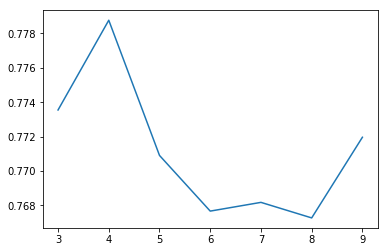

In [27]:
plt.plot(range(3,10),cvs)

In [39]:
l.fit(all_train_df, ytrain)
preds = l.predict(all_test_df)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [44]:
pd.DataFrame({'Id': test[id_cols].values, 'Cover_Type':preds}).to_csv('Submissions/base_lgbm.csv',index=False)